<font size="5"><b>Final Project Report Group 42- Heart Failure Fatality</b></font>

**Introduction**
    
Cardiovascular diseases kill approximately 17 million people in the world, including heart attacks, strokes, and heart failure. In particular, heart failure is caused when the heart cannot successfully send the required amount of blood to the body (Chicco, 2020), and can occur for numerous reasons such as diabetes, high blood pressure, and other heart conditions or diseases. With the emergence and accessibility of electronic health records, it is now possible to use data from patients who have experienced heart failure and find trends and patterns amongst variables that could be possible predictors for people who are at risk of heart failure. Due to the vital nature of the heart finding trends among variables as predictors of heart failure has become a priority among doctors and researchers alike. Our project was to take a data set comprised of data taken from people who had suffered from heart failure and build a classifying model that could predict a person's chance of survival after heart failure. A data set collected at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad contains the data of 299 patients which consisted of 105 women and 194 men who had all experienced heart failure. The dataset contained 13 features which ranged from physical, clinical, and lifestyle characteristics. This included categorical variables like sex, diabetes, and smoking; as well as numerical variables such as platelet count, serum creatine levels, and ejection fraction. This data set also contained the information on whether the patient had died in the 130 days follow-up after their heart failure referred to as a death event. Through the use of forward selection, we were able to identify two variables that were strong predictors of death events. These two variables, serum creatine and ejection fraction were used to build our classifying model that would take in the values of our predictors and classify whether this patient would experience a death event or not following 130 days after heart failure. This classifier would allow us to answer the question of if given a person's serum creatine levels and ejection fraction will that person survive within 130 days after their heart failure?


**Methods and Results**

In [8]:
# Loading necessary packages
library(tidyverse)
library(tidymodels)
library(repr)

# Setting the seed to ensure reproducability 
set.seed(42)

# Setting the number of maximum rows which will be displayed whenever a data tibble needs to be outputed 
options(repr.matrix.max.rows = 6)

Firstly, appropriate packages were added to the file to use their inbuilt functions. A seed was set to ensure reproducibility so that the random values are always the same. And the maximum rows to be displayed when a tibble needs to be outputted was set to 6. 

In [9]:
#reads in data as well as turns relevant double columns into factors 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"

# tranforms the data variables which need to factors into the factor datatype 
heart_data <- read_csv(url)%>%
    mutate(sex = as_factor(sex))%>%
    mutate(smoking = as_factor(smoking))%>%
    mutate(DEATH_EVENT = as_factor(DEATH_EVENT))%>%
    mutate(high_blood_pressure = as_factor(high_blood_pressure))%>%
    mutate(diabetes = as_factor(diabetes))%>%
    mutate(anaemia= as_factor(anaemia)) 


#creates factor levels for columns that make sense with column name, not just 0 and 1 
levels(heart_data$sex) <- c("female","male")
levels(heart_data$smoking) <- c("no","yes")
levels(heart_data$DEATH_EVENT) <- c("died","survived")
levels(heart_data$high_blood_pressure) <- c("no","yes")
levels(heart_data$diabetes) <- c("no","yes")
levels(heart_data$anaemia) <- c("no","yes")

Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



Then, the dataset was read in as csv file. All the catagoriacal variables were transformed into factors datatype by using mutate function and as_factor function. As some columns include factors labeled "0" and "1", new factor levels were created with c function. These were as follows: 
- "female"/"male" in "sex"
- "no"/"yes" in "smoking" 
- "died"/"survived" in "DEATH_EVENT"
- "no"/"yes" in "high_blood_pressure"
- "no"/"yes" in "diabetes"
- "no"/"yes" in "aneamia"

In [10]:
#splits the data into training and testing data 
heart_data_split <- initial_split(heart_data, prop = .75, strata = DEATH_EVENT)
heart_train <- training(heart_data_split)
heart_test <- testing(heart_data_split)
 
heart_train

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>
75,no,582,no,20,yes,265000,1.9,130,male,no,4,survived
50,yes,111,no,20,no,210000,1.9,137,male,no,7,survived
90,yes,47,no,40,yes,204000,2.1,132,male,yes,8,survived
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,no,1820,no,38,no,270000,1.2,139,female,no,271,died
45,no,2060,yes,60,no,742000,0.8,138,female,no,278,died
45,no,2413,no,38,no,140000,1.4,140,male,yes,280,died


Here, the dataset was split into training data and testing data for classification. The training data consist of 75% of all rows randomly chosen from the dataset with initial_split function. This function siffles the data so no particular order/pattern is present in the 2 sets, and also stratifies the data so both sets have the same proportion of positive and negative classes. This makes the 2 sets comparable. The proportion 75% was chosen to use the vast majority of data for training while keeping sufficient number of observations for testing, regarding that our dataset only has 299 observations. This helps our model to be trained on the majority of the data hence being more accurate, while giving us sufficient data to evaluate its accuracy as well. This is one of the splits suggested in the course book as well (refer to the end of the notebook for reference). 

In [11]:
# remove non essential columns from the dataset and only keep numerical to run forward propagation
heart_train <- heart_train %>% 
    select(-anaemia, -diabetes, -high_blood_pressure, -sex, -smoking, -time)

Next, due to medical significance (Chicco, 2020), we decided that we will use "DEATH_EVENT" as our output variable which we will try to classify, hence we removed all the other categorical datatypes from the heart_test dataset using the select function. 

In [12]:
# CODE TO SELECT THE BEST PREDICTOR VARIABLES (code has been adapted from the DSCI 100 course book.) 
# (Citation is in references section)

# Evaluating which predictive variables to choose

# creating an object of names of all predictive variables called "names"
names <- colnames(heart_train %>% select(-DEATH_EVENT))

# creating an empty tibble to store the final results
accuracies <- tibble(size = integer(), 
                     model_string = character(), # this is the first argument to the "recipe" function
                     accuracy = numeric())

# creating a model specification for the classifier
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
     set_engine("kknn") %>% 
     set_mode("classification")

# creating a dataframe of all candidate k values 
k_vals <- tibble(neighbors = seq(1:10))

# creating a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_train, v = 5, strata = DEATH_EVENT)

# storing the total number of predictors in object "n_total"
n_total <- length(names)

# stores the selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("DEATH_EVENT", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_train) %>% 
                          step_scale(all_predictors()) %>% 
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>% 
              add_recipe(heart_recipe) %>% 
              add_model(heart_spec) %>% 
              tune_grid(resamples = heart_vfold, grid = k_vals) %>% 
              collect_metrics() %>% 
              filter(.metric == "accuracy") %>% 
              summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ ejection_fraction,0.6568423
2,DEATH_EVENT ~ ejection_fraction+serum_creatinine,0.7822354
3,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium,0.7994247
4,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase,0.7774879
5,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+age,0.7686957
6,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+age+platelets,0.7511111


Method (forward propagation): This code block ran an predictor variable selection algorithm called "forward propagation". This algorithm essentially “propagates” through all the variables, concatinating singular predictor variables after each other for every iteration of the loop. So, a k-nn classifier is built for each set of predictors, its best k value (from k = 1 to 15) and its appropriate accuracy is calculated. The subset of variables which return the higher values of accuracies are the ones which are appropriate for the classification. Ofcourse this is done with cross validation (5 v fold) to make sure our results are reliable. (Reasons for the attributes chosen for the k values and number of folds in cross validation are explained later. So is the detailed working of the k-nn classifier). This was achievable primarily due to the “paste” function which helped form a model specification for each set of predictor by concatinating them seperated with the “+” signs. as.formula function inside recipe function was used to add the model string. Moreover, two for loops were used to achieve this: the first one to account for the increasing predictor set sizes, and the second one to analyse which predictor to add to each cycle/iteration. An important factor which made us select this algorithm for our predictor variable selection was computational cost. There are many other (more productive) algorithms present for this task such as best subset selection, however most of them take a long time to run while not giving any significant difference in the overall accuracy of the classification. 

Result (forward propagation): The result of this evaluation showed that the top 2 accuracies are the second and the third rows. The accuracy predicted with ejection_fraction and serum_creatinine was 78.22% and that predicted with ejection_fraction, serum_creatinine, and serum_sodium was 79.94%. However, biologically, ejection fraction and serum creatinine alone are the best predictors of death event due to medical significance (Chicco, 2020). This does not differ from our evaluation as the accuracy of prediction with ejection_fraction and serum_creatinine is the second-highest. Therefore, these two numerical variables were chosen as predictive variables for our classification.

In [13]:
# selecting only appropriate columns from training set and testing set (ejection_fraction, serum_creatinine, DEATH_EVENT)
heart_train <- heart_train %>% 
    select(ejection_fraction, serum_creatinine, DEATH_EVENT)

heart_test<- heart_test%>%
    select(ejection_fraction, serum_creatinine, DEATH_EVENT)

In [14]:
set.seed(42)

# Making our classifier and using the variables found from forward propagation to find the best k value

# Creating variable k_vals which stores the candidate k values in form of a tibble
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

# Creating a recipe with recipe function, class = DEATH_EVENT and predictive variables are ejection_fraction
# and serum_creatinine. Only heart_train data is used with both the predictive variables scaled. 
final_recipe <- recipe(DEATH_EVENT ~ ejection_fraction+serum_creatinine, data = heart_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

# Creating a model specification for k-nn classification: argument for "neighbors" is set to tune() to 
# get best k value for the classification
kmin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

# Creating a 5 v fold cross validation argument with strata = DEATH_EVENT as that is the variable we want to predict
final_vfold <- vfold_cv(heart_train, v = 5, strata = DEATH_EVENT)

# Putting everything in a workflow, using tune_grid to repeat on all candidate k value with cross validation 
# and collect_metrics to calculate the accuracy for each run
kmin_results <- workflow() %>%
    add_recipe(final_recipe) %>% 
    add_model(kmin_spec) %>% 
    tune_grid(resamples = final_vfold, grid = k_vals) %>% 
    collect_metrics()

The code above creates our classifier and collects the accuracies foeach k candidate value. ****** TODO ******

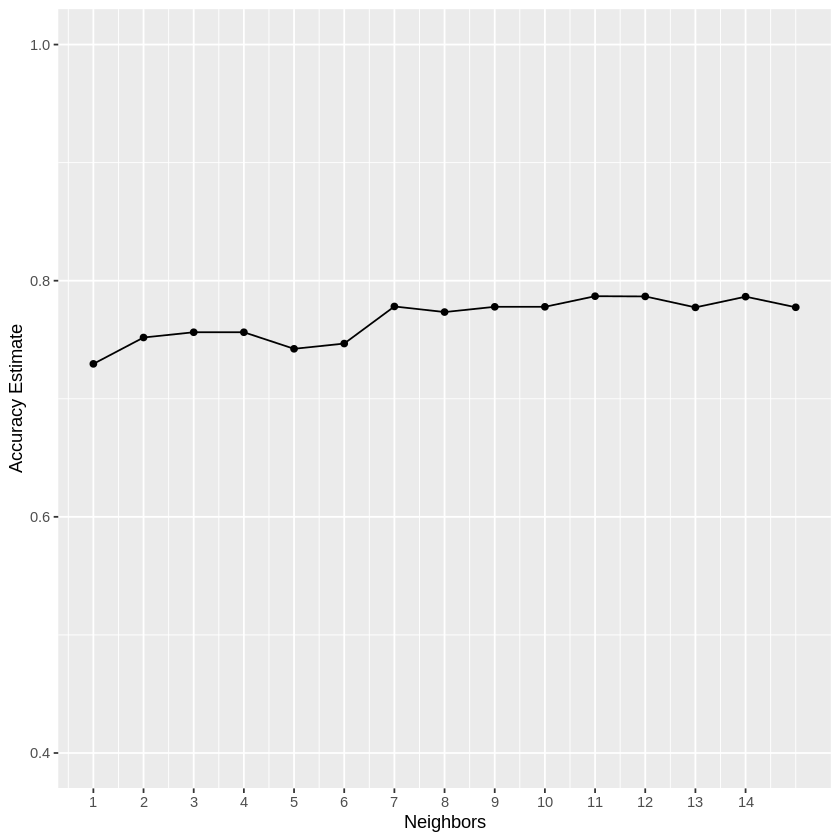

In [15]:
# Extracting only accuracy values from kminresults using filter function
final_accuracies <- kmin_results %>% 
    filter(.metric == "accuracy")

# Plotting a neighbors vs accuracy mean graph to see which k is the best
accuracy_versus_k <- ggplot(final_accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

We then plotted a graph for the mean accuracy which was recieved after collecting the metrics for every k value. As we can notice from the graph, any k value ranging from 7 to 15 gives around the same accuracy level, so ant of them can be used, however, since the actual peaks are k = 11, 12 and 14, these are now the candidates for our final k value. We now find the best k value using the arrange 

In [16]:
# Extracting the k value which offers the maximum accuracy from kmin_results
k_min <- kmin_results %>% 
    filter(.metric == "accuracy") %>% 
    arrange(-mean) %>% 
    slice(1) %>% 
    select(neighbors, mean) %>% 
    rename(accuracy = mean)
k_min

neighbors,accuracy
<dbl>,<dbl>
11,0.7868775


Best K = 11, accuracy = 78.7% 

In [17]:
# Retraining with the chosen K value of 11
set.seed(42)

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

final_fit  <- workflow() %>%
    add_recipe(final_recipe) %>% 
    add_model(final_spec) %>% 
    fit(data = heart_train)

heart_prediction <- predict(final_fit, heart_test) %>% 
    bind_cols(heart_test)

heart_prediction_accuracy <- heart_prediction %>% 
    metrics(truth = DEATH_EVENT, estimate = .pred_class) %>% 
    filter(.metric == "accuracy")
heart_prediction_accuracy

#added a reference point using a majority classifier if it predicted died everytime it would have 68% accuracy.
heart_data_proportions <- heart_train %>%
                      group_by(DEATH_EVENT) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(heart_train))

heart_data_proportions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7162162


`summarise()` ungrouping output (override with `.groups` argument)



DEATH_EVENT,n,percent
<fct>,<int>,<dbl>
died,153,68
survived,72,32


In [18]:
heart_prediction_confusion <- heart_prediction %>% 
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)
heart_prediction_confusion

          Truth
Prediction died survived
  died       40       11
  survived   10       13

Explain how we only care about the 11 wrong classificationa when the the truth = died and prediction = survived as those are the people who will not get approporiate healthcare to avoid death. Hence overall critical accuracy is around 10/(40+10+11+13) ~= %

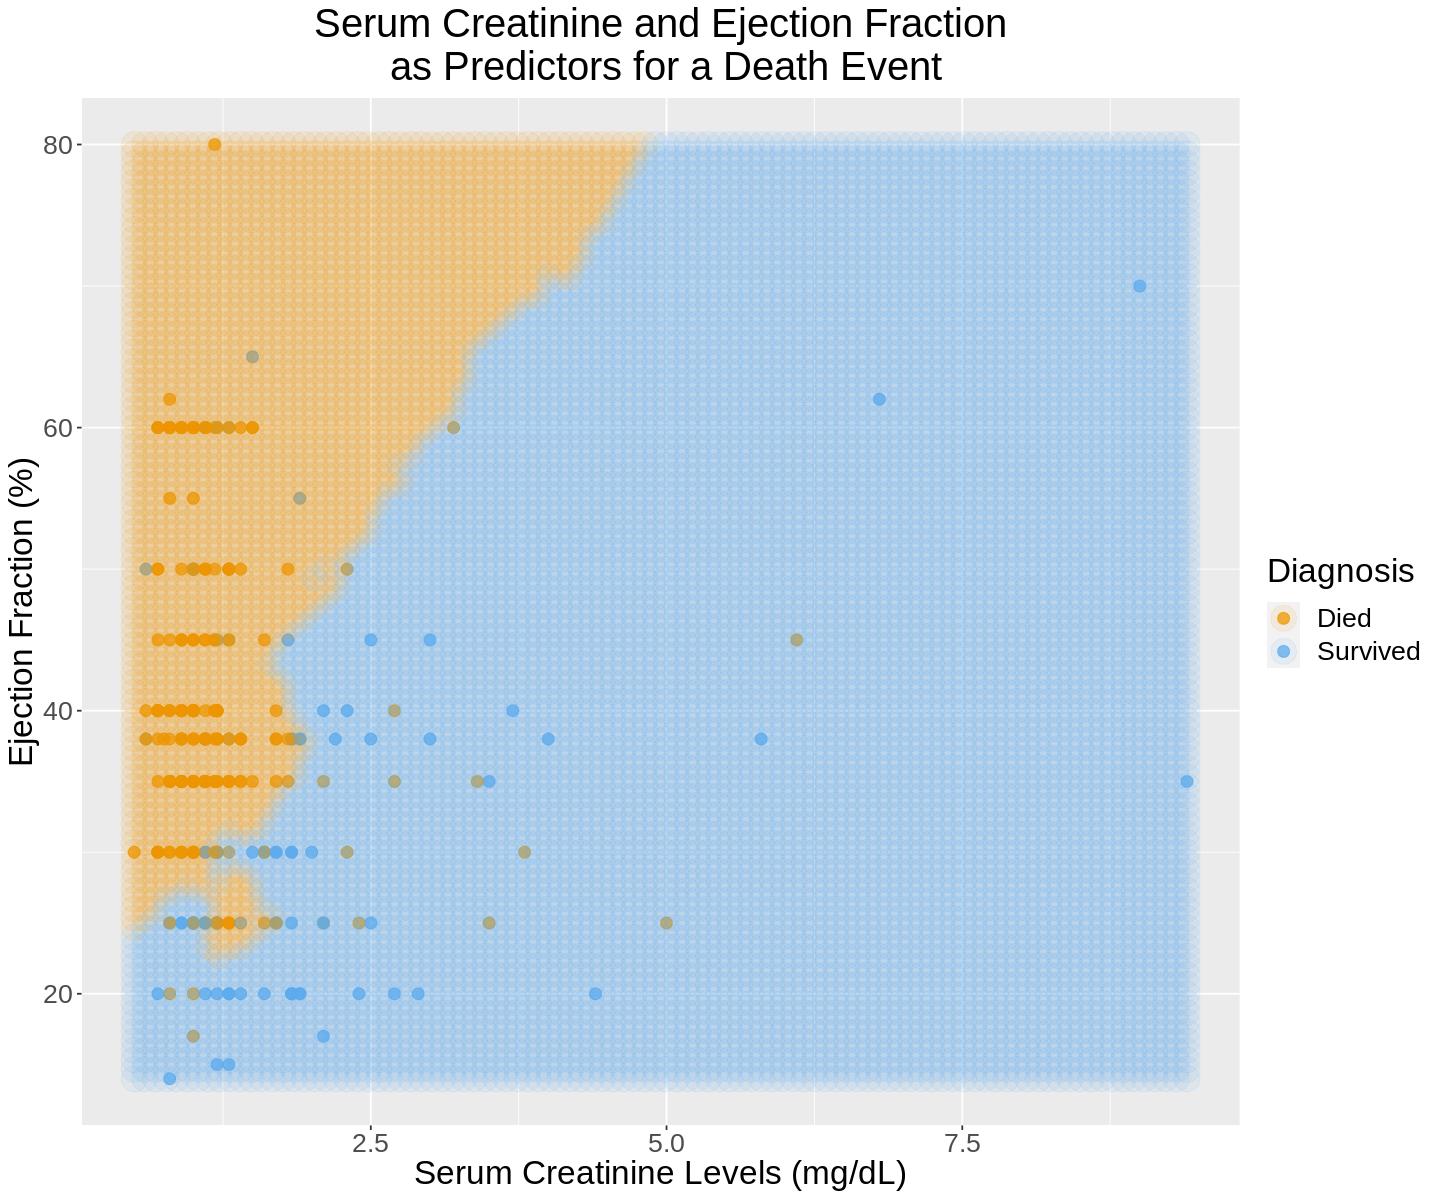

In [19]:
set.seed(42)
# Making a prediction boundry plot for the classifier 
options(repr.plot.height = 10, repr.plot.width = 12)

#scaling all the data before plotting it
graph_data <- heart_data

# recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = heart_data)%>%
#     step_scale(all_predictors())%>%
#     step_center(all_predictors())%>%
#     prep()%>%
#     bake(heart_data)


# create the grid of area/smoothness vals, and arrange in a data frame
ef_grid <- seq(min(graph_data$ejection_fraction), 
                max(graph_data$ejection_fraction), 
                length.out = 100)
sc_grid <- seq(min(graph_data$serum_creatinine), 
                max(graph_data$serum_creatinine), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(ejection_fraction = ef_grid, 
                                serum_creatinine = sc_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(final_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
  rename(DEATH_EVENT = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
heart_prediction_plot <-
  ggplot() +
  geom_point(data = graph_data, 
             mapping = aes(x = serum_creatinine, 
                           y = ejection_fraction, 
                           color = DEATH_EVENT), 
             alpha = 0.75, 
             size = 3) +
  geom_point(data = prediction_table, 
             mapping = aes(x = serum_creatinine, 
                           y = ejection_fraction, 
                           color = DEATH_EVENT), 
             alpha = 0.09, 
             size = 7) +
  labs(color = "Diagnosis", x = "Serum Creatinine Levels (mg/dL)", y = "Ejection Fraction (%)", 
         title = "Serum Creatinine and Ejection Fraction\n as Predictors for a Death Event") +
  scale_color_manual(labels = c("Died", "Survived"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 20), plot.title = element_text(hjust = .5))

heart_prediction_plot

**Discussion**


The initial running of our forward selection model found that our best predictors of Death Events were serum creatine levels and ejection fraction.  Serum creatine is a waste product generated by creatine when muscle breakdowns(Chicco, 2020). Serum creatine is normally removed from the bloodstream via the kidneys but high levels of serum creatine may be an indication of renal dysfunction (Cole et al., 2012).  Renal dysfunction is a common comorbidity with acute and chronic heart failure however the complex interactions between the two are still poorly understood in the scientific community (Cole et al., 2012).  The Ejection Fraction is the proportion of blood pumped out through one contraction of the heart and in this data set is given as a percentage (Chicco, 2020).  While these predictors by themselves each have their own impact and connection to heart failure it was unclear what patterns and trends they would have when used together to predict a Death Event. We began by assembling a model using these two variables as predictors. Through the use of cross-validation and tune_grid() functions we ran our model on a range of k values from 1 to 15. We chose these values to give us the widest range of possible k values to build our model without getting too computationally costly. For our cross-validation model, we chose to do 5 folds in order to attain good accuracy without slowing increasing the computation time of our model. From this we found k = 7 to have the highest accuracy. After running our model with k = 7 we found that our model had an accuracy of 71%. When creating a confusion matrix it showed that our model had predicted 11 deaths as a classification for patients that had actually survived. Even though our model had incorrectly classified these observations we decided to include them as an accurate prediction since in a hospital setting this patient would still have survived. The more “critical” misclassifications, where our model predicted someone's survival when they died, added up to 11 as well. If we counted only does classifications as misclassifications it brought our total accuracy up to 84%. Our majority classifier which predicted the death of the patient every time had an accuracy of 68%. When we compare our model on a purely classification accuracy base it did not perform well. 71% is not acceptable when that means that potentially 30% of the cases will be misclassified which could result in numerous patients deaths. This also only slightly higher than our majority classification of 68% meaning that our model is barely outperforming a model that takes in zero input data. Even only focusing on the “critical” misclassifications which brought our model accuracy up to 84% is not acceptable for being responsible to predict who may be at risk of death. This data is perhaps not surprising given the vastly different biological roles our two predictors are involved with. Serum creatinine being related to renal dysfunction and ejection fraction being the heart's ability to pump blood do not appear to be related at all on the surface. While there are possible connections between renal dysfunction and heart failure it seemed unlikely that those two as predictors would be able to accurately predict a patient's chance of survival post heart failure. This findings further complicate the potential connections that can be drawn between kidney failure and heart failure. In order to better understand these connections, future studies may want to investigate other common indicators of kidney failure and heart failure and discover if any patterns or trends lie between them as predictors of survival.

